<a href="https://colab.research.google.com/github/daniswara10/DeteksiPapanNamaFilkomDenganCvT/blob/main/ProjectCvT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install ultralytics
!pip install torch torchvision torchaudio
!pip install matplotlib opencv-python
!pip install seaborn

In [12]:
pip install ultralytics


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import torch
import torch.nn as nn
from transformers import ViTModel

# CNN Backbone
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 32 * 32, 512)  # assuming 32x32 image size after conv layers

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 32 * 32)  # flatten feature map
        x = F.relu(self.fc(x))
        return x

# Transformer head
class CvTModel(nn.Module):
    def __init__(self):
        super(CvTModel, self).__init__()
        self.cnn_backbone = CNNBackbone()
        self.transformer = ViTModel.from_pretrained('google/vit-base-patch16-224')

    def forward(self, x):
        cnn_features = self.cnn_backbone(x)
        transformer_input = cnn_features.unsqueeze(1)  # adjust shape for transformer
        transformer_output = self.transformer(transformer_input)
        return transformer_output.last_hidden_state


In [16]:
from ultralytics import YOLO
import numpy as np

class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        """
        :param patience: Jumlah epoch untuk menunggu jika tidak ada perbaikan
        :param delta: Perubahan minimum yang dianggap sebagai perbaikan
        :param verbose: Menampilkan informasi tambahan jika True
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = np.inf  # Untuk loss lebih rendah, set initial score ke inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, score):
        if self.best_score - score > self.delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

# Definisikan model, misalnya YOLOv8
model = YOLO('/content/drive/MyDrive/Deteksipapannamafilkom/Sebelum Early Stop/best.pt')  # Atau model yang Anda pilih

# Setup early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Train model for one epoch
    results = model.train(data='//content/drive/MyDrive/Deteksipapannamafilkom/data.yaml', epochs=1, batch=16, imgsz=640, save=True, exist_ok=True)

    # Coba akses loss dari hasil pelatihan
    try:
        if hasattr(results, 'metrics'):
            # Misalkan 'loss' berada di dalam 'results.metrics'
            val_loss = results.metrics.get('loss', np.inf)
        else:
            # Alternatif: Cek dokumentasi atau hasil pelatihan
            print("Metrics tidak tersedia dalam hasil pelatihan")
            val_loss = np.inf
    except Exception as e:
        print(f'Error saat mengambil loss: {e}')
        val_loss = np.inf

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Panggil early stopping
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Deteksipapannamafilkom/Sebelum Early Stop/best.pt, data=//content/drive/MyDrive/Deteksipapannamafilkom/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

train: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/train/labels.cache... 2205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.56G      1.031      0.607      1.078         15        640: 100%|██████████| 138/138 [11:50<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        245        245       0.94      0.976      0.978      0.708

1 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


                   all        245        245       0.94      0.976      0.978      0.708
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train
Metrics tidak tersedia dalam hasil pelatihan
Epoch 1/50, Validation Loss: inf
EarlyStopping counter: 1 out of 5
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Deteksipapannamafilkom/Sebelum Early Stop/best.pt, data=//content/drive/MyDrive/Deteksipapannamafilkom/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_rati

train: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/train/labels.cache... 2205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1       2.5G     0.9485     0.5613       1.05         15        640: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


                   all        245        245      0.936      0.971      0.975      0.687

1 epochs completed in 0.025 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


                   all        245        245      0.936      0.971      0.975      0.686
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train
Metrics tidak tersedia dalam hasil pelatihan
Epoch 2/50, Validation Loss: inf
EarlyStopping counter: 2 out of 5
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Deteksipapannamafilkom/Sebelum Early Stop/best.pt, data=//content/drive/MyDrive/Deteksipapannamafilkom/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_rati

train: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/train/labels.cache... 2205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.44G     0.8924     0.5302      1.022         15        640: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


                   all        245        245       0.96      0.955      0.982      0.699

1 epochs completed in 0.034 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


                   all        245        245       0.96      0.955      0.982        0.7
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train
Metrics tidak tersedia dalam hasil pelatihan
Epoch 3/50, Validation Loss: inf
EarlyStopping counter: 3 out of 5
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Deteksipapannamafilkom/Sebelum Early Stop/best.pt, data=//content/drive/MyDrive/Deteksipapannamafilkom/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_rati

train: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/train/labels.cache... 2205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.44G     0.8334     0.5081     0.9991         15        640: 100%|██████████| 138/138 [01:06<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


                   all        245        245      0.941      0.943      0.972      0.663

1 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


                   all        245        245      0.941      0.943      0.972      0.663
Speed: 0.4ms preprocess, 3.5ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/train
Metrics tidak tersedia dalam hasil pelatihan
Epoch 4/50, Validation Loss: inf
EarlyStopping counter: 4 out of 5
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Deteksipapannamafilkom/Sebelum Early Stop/best.pt, data=//content/drive/MyDrive/Deteksipapannamafilkom/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_rati

train: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/train/labels.cache... 2205 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2205/2205 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.53G     0.7959     0.4867      0.983         15        640: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


                   all        245        245      0.925      0.962      0.981      0.699

1 epochs completed in 0.028 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


                   all        245        245      0.925      0.963      0.981      0.698
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train
Metrics tidak tersedia dalam hasil pelatihan
Epoch 5/50, Validation Loss: inf
EarlyStopping counter: 5 out of 5
Early stopping


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


                   all        245        245      0.929      0.966      0.983      0.701
Speed: 0.8ms preprocess, 5.9ms inference, 0.2ms loss, 4.6ms postprocess per image
Results saved to runs/detect/val5


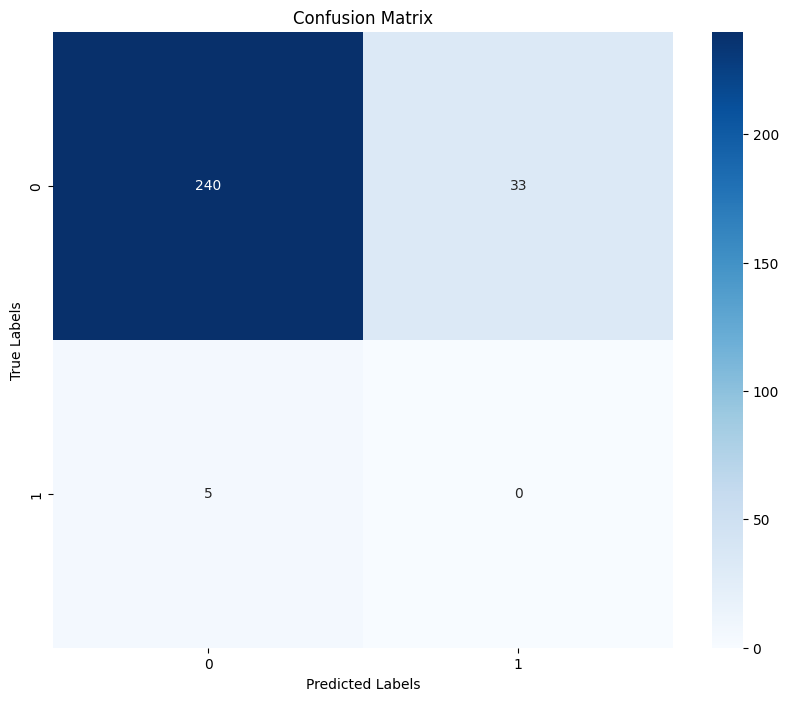

Akurasi: 86.33%

Kelas 1:
   Precision: 97.96%
   Recall: 87.91%
   F1-Score: 92.66%
   Specificity: 0.00%

Kelas 2:
   Precision: 0.00%
   Recall: 0.00%
   F1-Score: nan%
   Specificity: 87.91%


<ipython-input-20-2ef67f3a35d1>:44: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

# Load model YOLOv8 yang sudah dilatih
model = YOLO('/content/drive/MyDrive/Deteksipapannamafilkom/best.pt')  # Ganti 'best.pt' dengan path ke model YOLOv8 yang sudah Anda latih

# Lakukan validasi model
results = model.val()

# Ambil data confusion matrix
conf_matrix = results.confusion_matrix.matrix

# Coba konversi ConfusionMatrix ke numpy array (misalnya, jika itu objek khusus)
try:
    conf_matrix = np.array(conf_matrix)  # Mengonversi ke numpy array
except:
    print("Gagal mengonversi confusion matrix menjadi array.")

# Pastikan confusion_matrix sekarang adalah array 2D
if conf_matrix is not None and len(conf_matrix.shape) == 2:
    # Visualisasikan confusion matrix dengan Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Hitung metrik berdasarkan confusion matrix
    TP = np.diag(conf_matrix)  # True Positives (diagonal dari confusion matrix)
    FP = np.sum(conf_matrix, axis=0) - TP  # False Positives (kolom prediksi)
    FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives (baris ground truth)
    TN = np.sum(conf_matrix) - (FP + FN + TP)  # True Negatives

    # Akurasi
    accuracy = np.sum(TP) / np.sum(conf_matrix)
    print(f'Akurasi: {accuracy * 100:.2f}%')

    # Precision, Recall, F1-Score, dan Specificity untuk setiap kelas
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)

    # Tampilkan metrik untuk setiap kelas
    for i in range(len(TP)):
        print(f'\nKelas {i + 1}:')
        print(f'   Precision: {precision[i] * 100:.2f}%')
        print(f'   Recall: {recall[i] * 100:.2f}%')
        print(f'   F1-Score: {f1_score[i] * 100:.2f}%')
        print(f'   Specificity: {specificity[i] * 100:.2f}%')

else:
    print("Confusion matrix tidak tersedia atau tidak berbentuk 2D.")


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        245        245      0.929      0.966      0.983      0.701
Speed: 0.9ms preprocess, 9.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train


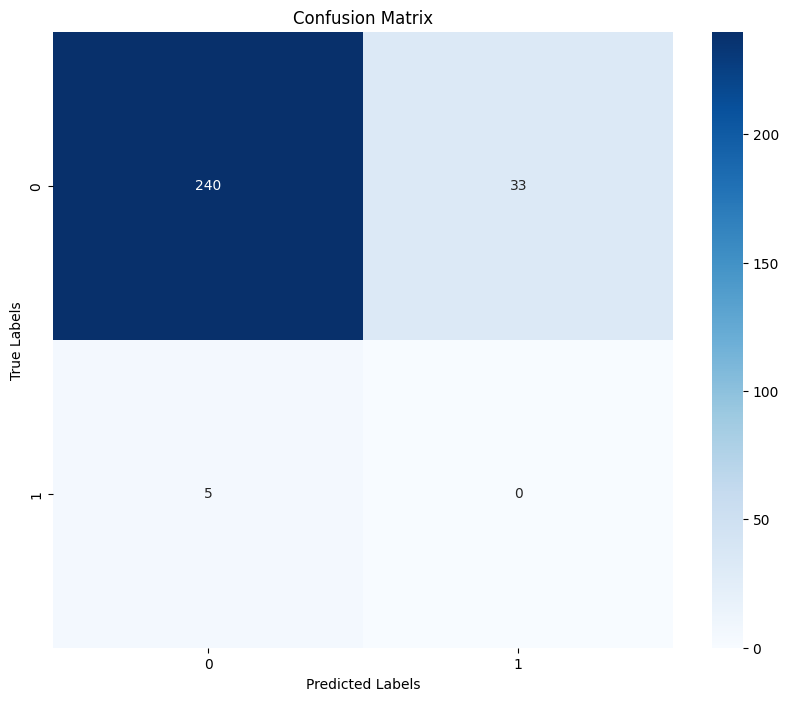

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Lakukan validasi model
results = model.val()

# Ambil data confusion matrix
conf_matrix = results.confusion_matrix.matrix

# Coba konversi ConfusionMatrix ke numpy array (misalnya, jika itu objek khusus)
try:
    conf_matrix = np.array(conf_matrix)  # Mengonversi ke numpy array
except:
    print("Gagal mengonversi confusion matrix menjadi array.")

# Pastikan confusion_matrix sekarang adalah array 2D
if conf_matrix is not None and len(conf_matrix.shape) == 2:
    # Visualisasikan confusion matrix dengan Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Confusion matrix tidak tersedia atau tidak berbentuk 2D.")

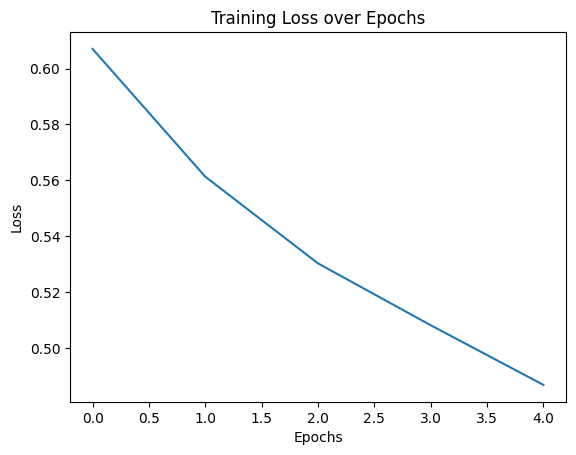

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/runs/detect/train/results.csv')
loss = df['         train/cls_loss']


# Extract epoch and loss values
epochs = [i for i in range(len(loss))]
losses = [metric for metric in loss]

plt.plot(epochs, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


In [9]:
# Memuat model YOLOv8 dengan CvT yang sudah dilatih
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Ganti dengan path model Anda

# Menampilkan parameter model (weights dan biases)
for name, param in model.model.named_parameters():  # Akses model dari objek YOLO
    print(f"Parameter Name: {name}")
    print(f"Parameter Value: {param}")
    print(f"Parameter Size: {param.size()}")
    print('-' * 80)

Streaming output truncated to the last 5000 lines.

         [[ 0.0053]]],


        [[[-0.0309]],

         [[ 0.0538]],

         [[ 0.0254]],

         ...,

         [[ 0.0123]],

         [[ 0.0275]],

         [[-0.0116]]],


        [[[ 0.0093]],

         [[-0.0473]],

         [[ 0.0302]],

         ...,

         [[ 0.0211]],

         [[ 0.0378]],

         [[ 0.0211]]],


        ...,


        [[[-0.0235]],

         [[-0.0131]],

         [[-0.0487]],

         ...,

         [[ 0.0042]],

         [[ 0.0235]],

         [[-0.0002]]],


        [[[ 0.0067]],

         [[ 0.0392]],

         [[ 0.0449]],

         ...,

         [[ 0.0848]],

         [[ 0.0507]],

         [[-0.0489]]],


        [[[ 0.0158]],

         [[-0.0557]],

         [[-0.0427]],

         ...,

         [[-0.0912]],

         [[ 0.0218]],

         [[-0.0424]]]])
Parameter Size: torch.Size([64, 192, 1, 1])
--------------------------------------------------------------------------------
Parameter

In [10]:
import time
from ultralytics import YOLO

# Memuat model YOLOv8 dengan CvT yang sudah dilatih
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Ganti dengan path model Anda

# Mengukur waktu deteksi pada data uji
start_time = time.time()
results = model.val()  # Melakukan validasi pada data uji
end_time = time.time()

# Menghitung waktu deteksi
inference_time = end_time - start_time
print(f"Validation Time: {inference_time:.4f} seconds")


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Deteksipapannamafilkom/valid/labels.cache... 245 images, 0 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


                   all        245        245      0.929      0.966      0.983      0.701
Speed: 0.5ms preprocess, 4.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val
Validation Time: 8.6069 seconds


In [11]:
print(model.info())

Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
(168, 3005843, 0, 8.0851968)


In [22]:
# Gambar yang akan diprediksi
img_path = '/content/drive/MyDrive/Deteksipapannamafilkom/test/images/1026_jpg.rf.0d3ae3207012550ba89a4422ba36a0aa.jpg'  # Ubah ke path gambar yang akan diuji


In [23]:
# Deteksi objek pada gambar
results = model(img_path)



image 1/1 /content/drive/MyDrive/Deteksipapannamafilkom/test/images/1026_jpg.rf.0d3ae3207012550ba89a4422ba36a0aa.jpg: 640x640 2 papan_namas, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


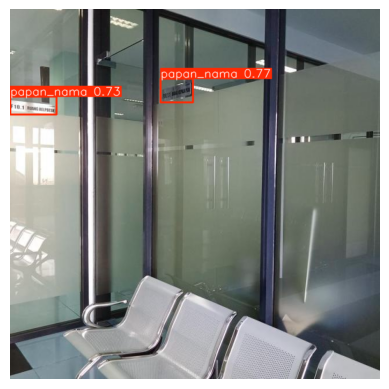

In [24]:
# Ambil gambar hasil deteksi
detected_img = results[0].plot()  # Plot hasil deteksi

# Tampilkan gambar menggunakan matplotlib
plt.imshow(detected_img)
plt.axis('off')  # Hilangkan axis
plt.show()  # Tampilkan gambar
